### Overview:

In this notebook the insights gained from exploratory analysis are used to help answer the question surrounding proper stocking requirements for Divvy stations. The goal was to create a model to predict the ratio of trips in / trips out of any given station by day of the week and month of the year. This would allow Divvy to compare this predicted ratio with the current stocking status of their stations.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import datetime as dt

In [2]:
df = pd.read_csv('Divvy_data_2017T2.csv')

In [3]:
df.rename(columns={'start_station_trip_count': 'start_trips_whole_year'}, inplace=True)

In [4]:
df.start_time = pd.to_datetime(df.start_time, format='%Y-%m-%d  %H:%M:%S')
df = df.set_index('start_time')
df['month_of_year'] = df.index.month

### First we need to define our target and predictor variables

In [5]:
#find the number of trips leaving each station by day of the week and month of the year
stations_out = df.groupby(['start_station_id', 'day_of_week', 'month_of_year']).count()

#Not all stations had trips arrive at them every single day of the year. These are not currently shown as empty values, data does
#not appear for those days at all. Unstack the month and day of week, to view information for all days, and fill NaN's with 0's.
out = stations_out.unstack(['month_of_year', 'day_of_week'])
out = out.fillna(0)

In [6]:
out.head()

trip_id                                              ...   \
month_of_year         1    2    3    4    5    6    7    8    9    10 ...    
day_of_week            0    0    0    0    0    0    0    0    0    0 ...    
start_station_id                                                      ...    
2                     12   75   51  128  273  322  536  270  330  145 ...    
3                     38  171  107  228  556  477  912  682  614  394 ...    
4                     15  101   28  182  469  399  744  377  431  251 ...    
5                     24   51   35   60  124  147  231  138   95  113 ...    
6                     21   99   41   54  443  398  655  420  417  316 ...    

                 week_of_year                                                 
month_of_year              3    4    5    6     7    8     9    10   11   12  
day_of_week                 6    6    6    6     6    6     6    6    6    6  
start_station_id                                                              
2                          57  293  286  463   749  357   623  162   20   11  
3                         186  585  760  876  1248  796  1020  631  188  113  
4                          74  505  595  867  1052  595   635  369   76   56  
5                          16   63   89  156   197   99    94   89   17   12  
6                         119  404  557  834  1038  759   745  442   66   69  

[5 rows x 2184 columns]

In [7]:
#restack the day and month so we can see the number of trips broken down by these variables with the 0s filled in 
a = out.stack(['day_of_week', 'month_of_year'])

In [8]:
#find the number of trips arriving at each station by day of the week and month of the year
stations_in = df.groupby(['end_station_id', 'day_of_week', 'month_of_year']).count()

#Not all stations had trips leave from them every single day of the year. These are not currently shown as empty values, data does
#not appear for those days at all. Unstack the month and day of week, to view information for all days, and fill NaN's with 0's.
ins = stations_in.unstack(['month_of_year', 'day_of_week'])
ins = ins.fillna(0)

In [9]:
#restack the day and month so we can see the number of trips broken down by these variables with the 0s filled in 
b = ins.stack(['day_of_week', 'month_of_year'])

In [10]:
#create a function to find the trips coming in to trips going out ratio for each station
def io_ratio():
    station_ios = []
    
    #49140 is how many observations there our in our data broken down by station, day of week, and month of the year
    for row in range(0, 49140):
        if int(a.trip_id.iloc[row]) == 0 & int(b.trip_id.iloc[row]) == 0:
            station_ios.append(1)
        elif b.trip_id.iloc[row] == 0:
            station_ios.append(1/a.trip_id.iloc[row])
        elif a.trip_id.iloc[row] == 0:
            station_ios.append(b.trip_id.iloc[row])
        else:
            io = float(b.trip_id.iloc[row]) / a.trip_id.iloc[row]
            station_ios.append(io)
    
    return station_ios


In [11]:
ratio = io_ratio()

In [12]:
#create a function to find the number of trips coming in and coming out of each station by day of the week and month.
def rides():
    rides_in = []
    rides_out =[]
    
    
    #49140 is how many observations there our in our data broken down by station, day of week, and month of the year
    for row in range(0, 49140):
            rides_in.append(b.trip_id.iloc[row])
            rides_out.append(a.trip_id.iloc[row])
    
    return rides_in, rides_out

In [13]:
i, o = rides()

In [14]:
avg_duration = df.groupby(['start_station_id', 'day_of_week', 'month_of_year']).mean()


In [15]:
dur = avg_duration.unstack(['month_of_year', 'day_of_week'])
dur = dur.fillna(0)
ad = dur.stack(['day_of_week', 'month_of_year'])

In [16]:
#create a function to find the number average duration starting from each station by day of the week and month.
def average_duration():
    avgdur = []
    
    
    #49140 is how many observations there our in our data broken down by station, day of week, and month of the year
    for row in range(0, 49140):
            avgdur.append(ad.trip_duration.iloc[row])
    
    return avgdur

avgdur = average_duration()

In [17]:
c = a.reset_index()
c['ratio'] = ratio
c['rides_in'] = i
c['rides_out'] = o
c['average_duration'] = avgdur


In [18]:
#add some additional features
add_features = df.groupby(['start_station_id', 'start_capacity', 'group', 'start_latitude', 'start_longitude' ]).count()
add_features = add_features.reset_index()
add_features = add_features[['start_station_id', 'start_capacity', 'group', 'start_latitude', 'start_longitude']]

In [19]:
af = c.merge(add_features, on='start_station_id')
c['capacity'] = af.start_capacity_y
c['group'] = af.group_y
c['latitude'] = af.start_latitude_y
c['longitude'] = af.start_longitude_y

In [20]:
c['start_station_id'] = c['start_station_id'].astype(float)
c['day_of_week'] = c['day_of_week'].astype(float)
c['month_of_year'] = c['month_of_year'].astype(float)
c['rides_in'] = c['rides_in'].astype(float)
c['rides_out'] = c['rides_out'].astype(float)
c['capacity'] = c['capacity'].astype(float)
c['group'] = c['group'].astype(float)

In [21]:
data = c[['start_station_id','day_of_week','month_of_year', 'capacity', 'group','latitude', 'longitude', 'average_duration', \
              'rides_in', 'rides_out', 'ratio',]]

In [22]:
data.latitude.median()

41.886922999999996

In [23]:
data.longitude.median()

-87.65383299999998

In [24]:
sections = []

for i in data['latitude']:
    if i >= 41.886923:
        sections.append(1)
    else:
        sections.append(0)
    

In [25]:
data['section'] = sections

C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
territory = []

north = data.loc[data.section ==1]
south = data.loc[data.section ==0]

for i in north['longitude']:
    if i < -87.653833:
        territory.append(1)
    else:
        territory.append(2)
        
for i in south['longitude']:
    if i < -87.653833:
        territory.append(3)
    else:
        territory.append(4)
        

        
    

In [27]:
data['territory'] = territory

C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [28]:
#add in the date when the bike stations went live

online = df[['start_station_id','start_online_date']]
online1 = online.drop_duplicates('start_station_id')
online1['start_online_date'] = pd.to_datetime(online1['start_online_date'])

C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
online1 = online1.sort_values('start_station_id')
online1.head()

,start_station_id,start_online_date
start_time,,
2017-03-31 22:52:02,2,2013-06-10 10:43:00
2017-03-31 17:19:34,3,2013-06-10 10:44:00
2017-03-31 19:13:42,4,2013-06-10 10:46:00
2017-03-31 22:37:14,5,2013-06-10 10:46:00
2017-03-31 20:16:59,6,2013-06-10 11:18:00


In [30]:
years = []
for i in range(0,585):
    years.append(online1.start_online_date[i].year)
    
online1['year_online'] = years

months = []

for i in range(0,585):
    months.append(online1.start_online_date[i].month)
    
online1['month_online'] = months
    

In [31]:
online_dates = online1[['start_station_id', 'year_online', 'month_online']]

In [32]:
data = data.merge(online_dates, on='start_station_id')

In [33]:
#group stations by capacities
data.capacity.describe()


count    49140.000000
mean        17.507692
std          6.670351
min         11.000000
25%         15.000000
50%         15.000000
75%         19.000000
max         55.000000
Name: capacity, dtype: float64

In [34]:
capgs = []

for i in data['capacity']:
    if i < 15:
        capgs.append(1)
    elif i == 15:
        capgs.append(2)
    elif i < 20:
        capgs.append(3)
    elif i >= 20:
        capgs.append(4)

In [35]:
data['cap_group'] = capgs

### To predict the stocking ratio for all stations it may be helpful to segment the stations into groups and train models for each groups intricacies. Here we'll group stations based on their size using the cap_group designations.

In past analysis we've found that the average ratio between stations capacities does not differ significantly but the variance is much higher for the lower capacity stations. Grouping in this way will also help predict the ratio for new stations. (If we grouped by traffic level for instatnce, we would not have any trip information for a brand new station to place it correctly.)


In [36]:
group1 = data.loc[data.cap_group == 1]
Xg1 = group1[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory', 'section', 'year_online','month_online', 'group']]
yg1 = group1['ratio']

group2 = data.loc[data.cap_group == 2]
Xg2 = group2[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory', 'section', 'year_online','month_online', 'group']]
yg2 = group2['ratio']

group3 = data.loc[data.cap_group == 3]
Xg3 = group3[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory', 'section', 'year_online','month_online', 'group']]
yg3 = group3['ratio']

group4 = data.loc[data.cap_group == 4]
Xg4 = group4[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory', 'section', 'year_online','month_online', 'group']]
yg4 = group4['ratio']


In [37]:
#predictor variables
X = data[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory', 'section', 'year_online','month_online', 'group']]

In [38]:
#target variable
y = data['ratio'].values

### Feature Selection

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

lasso = Lasso()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=15)

lasso_coef = lasso.fit(X_train,y_train).coef_

lasso_coef

array([-0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.])

None of the variables have strong coefficents, so we will use all predictor varibles while creating our models 

In [40]:
#prep categorical variables to utilize the get_dummies function
X.group = X.group.astype('category')
X.month_of_year = X.month_of_year.astype('category')
X.day_of_week = X.day_of_week.astype('category')
X.section = X.section.astype("category")
X.territory = X.territory.astype('category')

Xg1.group = X.group.astype('category')
Xg1.month_of_year = X.month_of_year.astype('category')
Xg1.day_of_week = X.day_of_week.astype('category')
Xg1.section = X.section.astype("category")
Xg1.territory = X.territory.astype('category')

C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\pandas\core\generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [41]:
X = pd.get_dummies(X)
Xg1 = pd.get_dummies(Xg1)

### We will also need a baseline to compare our model against later on

This will allow us to see how well our models compare against just using the average ratio for each station for the year as a whole.

In [42]:
#count number of rides out per station for 2017
rout = df.groupby(['start_station_id']).count()

#count number of rides in per station for 2017
rin = df.groupby(['end_station_id']).count()

In [43]:
# get the infromation for trips in and trips out ready for a join
i = pd.DataFrame(rin.trip_id)
o = pd.DataFrame(rout.trip_id)
i.rename(columns={'trip_id': 'trips_in'}, inplace=True)
o.rename(columns={'trip_id': 'trips_out'}, inplace=True)
i.index.names = ['station_id']
o.index.names= ['station_id']

# join trips in and out into one dataframe
io = i.join(o, how='outer')
io['2017_ratio'] = io.trips_in / io.trips_out

io = io.drop(['trips_in', 'trips_out'], axis=1)
io = io.reset_index()

In [44]:
data = data.merge(io, left_on='start_station_id', right_on='station_id')
data = data.drop('station_id', axis=1)

### Now that we have our predictor and target variables, we can split the data into training and tests sets, and train a model. 

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [46]:
steps=[('scaler', StandardScaler()), ('reg', LinearRegression())]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=15)
reg_scaled = pipeline.fit(X_train, y_train)

y_pred= pipeline.predict(X_test)

print pipeline.score(X_test, y_test)

0.009087623565337544


In [47]:
steps=[('scaler', StandardScaler()), ('reg', LinearRegression())]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(Xg1, yg1, test_size=.2, random_state=15)
reg_scaled = pipeline.fit(X_train, y_train)

y_pred= pipeline.predict(X_test)

print pipeline.score(X_test, y_test)

0.0026512744618963913


In [48]:
steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=.5, normalize=True))]

pipeline = Pipeline(steps)

parameters = {'ridge__alpha': [.1,.5,1,5,10]}

X_train, X_test, y_train, y_test = train_test_split(Xg1, yg1, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_

{'ridge__alpha': 1}


In [49]:
steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=.1, normalize=True))]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(Xg1, yg1, test_size=.2, random_state=15)
reg_scaled = pipeline.fit(X_train, y_train)

y_pred= pipeline.predict(X_test)

print pipeline.score(X_test, y_test)

0.0019294830660026019


### What if we separated out the target variable into classes that can be used for different stocking recommendations, and used our data for classification?

These stocking classes will be based on the trips in to trips out ratio, and will be separated in a way that a different recommendation can be made about stocking requirements for each class.

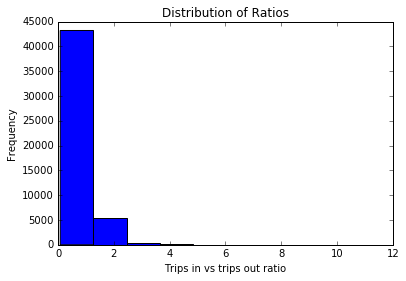

In [50]:
#view the distribution for the ratios - most seem to fall between 0 and 2
plt.hist(data.ratio)
plt.xlabel('Trips in vs trips out ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Ratios')
plt.show()

In [51]:
#separate the stock classes - different ratios would require different degrees of stocking needs

stockclass= []

def separate_stockclass():
    for i in range(len(c.ratio)):
        if data.ratio[i] < .5:
            stockclass.append('0 to .5')
        elif data.ratio[i] < .8:
            stockclass.append('.5 to .8')
        elif data.ratio[i] < 1.2:
            stockclass.append('.8 to 1.2')
        elif data.ratio[i] < 2.5:
            stockclass.append('1.2 to 2.5')
        elif data.ratio[i] >= 2.5:
            stockclass.append('2.5+')
        else:
            return 'Error'

In [52]:
separate_stockclass()

In [53]:
#new predictor and target variables for classification
data['class'] = stockclass
yc = data['class']
Xc = data[['day_of_week', 'month_of_year', 'average_duration', 'group', 'capacity', 'territory', 'year_online', 'month_online', 'section']]

#update the grouped predictor and target variables
g1c = group1[['day_of_week', 'month_of_year', 'average_duration', 'group', 'capacity', 'territory', 'year_online', 'month_online', 'section']]
g1yc = data['class'].loc[data.cap_group == 1]
g2c = group2[['day_of_week', 'month_of_year', 'average_duration', 'group', 'capacity', 'territory', 'year_online', 'month_online', 'section']]
g2yc = data['class'].loc[data.cap_group == 2]
g3c = group3[['day_of_week', 'month_of_year', 'average_duration', 'group', 'capacity', 'territory', 'year_online', 'month_online', 'section']]
g3yc = data['class'].loc[data.cap_group == 3]
g4c = group4[['day_of_week', 'month_of_year', 'average_duration', 'capacity', 'territory', 'year_online', 'month_online', 'group', 'section']]
g4yc = data['class'].loc[data.cap_group == 4]

### Create benchmarks to help evaluate our models going forward

In [54]:
#look at baseline performance for these new classes. As mentioned previously the average ratio per station for the year will act
#as our benchmark
baseline_results= []

def baseline():
    for i in range(len(c.ratio)):
        if data['2017_ratio'][i] < .5:
            baseline_results.append('0 to .5')
        elif data['2017_ratio'][i] < .8:
            baseline_results.append('.5 to .8')
        elif data['2017_ratio'][i] < 1.2:
            baseline_results.append('.8 to 1.2')
        elif data['2017_ratio'][i] < 2.5:
            baseline_results.append('1.2 to 2.5')
        elif data['2017_ratio'][i] >= 2.5:
            baseline_results.append('2.5+')
        else:
            return 'Error'


In [55]:
baseline()
data['baseline'] = baseline_results

In [56]:
#update the grouped dfs to include the class and baseline variables
group1 = data.loc[data.cap_group == 1]
group2 = data.loc[data.cap_group == 2]
group3 = data.loc[data.cap_group == 3]
group4 = data.loc[data.cap_group == 4]

In [57]:
#baseline performance for non-group model
a = data['class'].loc[data['class'] == data['baseline']]
float(len(a))/len(data)

0.6846764346764347

In [58]:
print classification_report(data['class'], data['baseline'])


             precision    recall  f1-score   support

   .5 to .8       0.23      0.06      0.10      5502
  .8 to 1.2       0.72      0.94      0.81     34657
    0 to .5       0.24      0.02      0.04       919
 1.2 to 2.5       0.34      0.09      0.15      7482
       2.5+       0.05      0.01      0.01       580

avg / total       0.59      0.68      0.61     49140



In [59]:
#baseline performance for group1
a = group1['class'].loc[group1['class'] == group1['baseline']]
float(len(a))/len(group1)

0.6102292768959435

In [60]:
print classification_report(group1['class'], group1['baseline'])

             precision    recall  f1-score   support

   .5 to .8       0.15      0.10      0.12      1115
  .8 to 1.2       0.71      0.83      0.77      6308
    0 to .5       0.00      0.00      0.00       315
 1.2 to 2.5       0.19      0.14      0.16      1129
       2.5+       0.05      0.02      0.03       205

avg / total       0.54      0.61      0.57      9072



C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
#baseline performance for group2
a = group2['class'].loc[group2['class'] == group2['baseline']]
float(len(a))/len(group2)

0.6367426347971095

In [62]:
print classification_report(group2['class'], group2['baseline'])

             precision    recall  f1-score   support

   .5 to .8       0.10      0.02      0.03      2677
  .8 to 1.2       0.66      0.95      0.78     14163
    0 to .5       0.24      0.04      0.07       482
 1.2 to 2.5       0.37      0.07      0.12      3963
       2.5+       0.00      0.00      0.00       303

avg / total       0.52      0.64      0.54     21588



In [63]:
#baseline performance for group3
a = group3['class'].loc[group3['class'] == group3['baseline']]
float(len(a))/len(group3)

0.7470501474926253

In [64]:
print classification_report(group3['class'], group3['baseline'])

             precision    recall  f1-score   support

   .5 to .8       0.19      0.02      0.03       924
  .8 to 1.2       0.76      0.98      0.85      7036
    0 to .5       0.00      0.00      0.00        98
 1.2 to 2.5       0.59      0.14      0.23      1388
       2.5+       0.00      0.00      0.00        46

avg / total       0.67      0.75      0.67      9492



In [65]:
#baseline performance for group4
a = group4['class'].loc[group4['class'] == group4['baseline']]
float(len(a))/len(group4)

0.8090787716955942

In [66]:
print classification_report(group3['class'], group3['baseline'])

             precision    recall  f1-score   support

   .5 to .8       0.19      0.02      0.03       924
  .8 to 1.2       0.76      0.98      0.85      7036
    0 to .5       0.00      0.00      0.00        98
 1.2 to 2.5       0.59      0.14      0.23      1388
       2.5+       0.00      0.00      0.00        46

avg / total       0.67      0.75      0.67      9492



## KNN

In [67]:
steps=[('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

parameters = {'knn__n_neighbors':np.arange(9,25)}

X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'knn__n_neighbors': 24}
0.7013380138380139


In [68]:
clf = KNeighborsClassifier(n_neighbors= 24)
X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

print classification_report(y_test, y_pred)

Training score:  0.7117165242165242
Test score:  0.7001424501424501
             precision    recall  f1-score   support

   .5 to .8       0.26      0.05      0.08      1104
  .8 to 1.2       0.72      0.98      0.83      6935
    0 to .5       0.00      0.00      0.00       186
 1.2 to 2.5       0.31      0.04      0.07      1482
       2.5+       0.00      0.00      0.00       121

avg / total       0.58      0.70      0.60      9828



Group 1

In [69]:
steps=[('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

parameters = {'knn__n_neighbors':np.arange(5,20)}

X_train, X_test, y_train, y_test = train_test_split(g1c, g1yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'knn__n_neighbors': 18}
0.6745211519911809


In [70]:
clf = KNeighborsClassifier(n_neighbors= 19)
X_train, X_test, y_train, y_test = train_test_split(g1c, g1yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

print classification_report(y_test, y_pred)

Training score:  0.7016673556566074
Test score:  0.699724517906336
             precision    recall  f1-score   support

   .5 to .8       0.27      0.12      0.17       208
  .8 to 1.2       0.74      0.95      0.83      1301
    0 to .5       0.00      0.00      0.00        64
 1.2 to 2.5       0.23      0.06      0.10       207
       2.5+       0.00      0.00      0.00        35

avg / total       0.59      0.70      0.63      1815



Group 2

In [71]:
steps=[('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

parameters = {'knn__n_neighbors':np.arange(9,25)}

X_train, X_test, y_train, y_test = train_test_split(g2c, g2yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'knn__n_neighbors': 24}
0.6479444122756225


In [72]:
clf = KNeighborsClassifier(n_neighbors= 24)
X_train, X_test, y_train, y_test = train_test_split(g2c, g2yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

print classification_report(y_test, y_pred)

Training score:  0.6615518239722061
Test score:  0.6387216303844372
             precision    recall  f1-score   support

   .5 to .8       0.11      0.01      0.03       564
  .8 to 1.2       0.66      0.97      0.78      2808
    0 to .5       0.00      0.00      0.00        90
 1.2 to 2.5       0.25      0.04      0.07       807
       2.5+       0.00      0.00      0.00        49

avg / total       0.49      0.64      0.53      4318



Group 3

In [73]:
steps=[('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

parameters = {'knn__n_neighbors':np.arange(9,25)}

X_train, X_test, y_train, y_test = train_test_split(g3c, g3yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'knn__n_neighbors': 19}
0.7375214012906625


In [74]:
clf = KNeighborsClassifier(n_neighbors= 23)
X_train, X_test, y_train, y_test = train_test_split(g3c, g3yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

print classification_report(y_test, y_pred)

Training score:  0.7445015145528776
Test score:  0.7424960505529226
             precision    recall  f1-score   support

   .5 to .8       0.12      0.01      0.02       187
  .8 to 1.2       0.75      0.99      0.85      1414
    0 to .5       0.00      0.00      0.00        18
 1.2 to 2.5       0.45      0.05      0.09       274
       2.5+       0.00      0.00      0.00         6

avg / total       0.64      0.74      0.65      1899



Group 4 

In [75]:
steps=[('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

parameters = {'knn__n_neighbors':np.arange(9,25)}

X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'knn__n_neighbors': 22}
0.8027816411682893


In [76]:
clf = KNeighborsClassifier(n_neighbors= 14)
X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

print classification_report(y_test, y_pred)

Training score:  0.8116828929068151
Test score:  0.8047830923248054
             precision    recall  f1-score   support

   .5 to .8       0.81      0.17      0.28       149
  .8 to 1.2       0.81      0.99      0.89      1425
    0 to .5       0.00      0.00      0.00         8
 1.2 to 2.5       0.42      0.05      0.09       208
       2.5+       0.00      0.00      0.00         8

avg / total       0.76      0.80      0.74      1798



## Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

steps=[('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rf__n_estimators':np.arange(5,20)}

X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'rf__n_estimators': 17}
0.6654202279202279


C:\Users\Danny\Miniconda2\envs\tutorial\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [78]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=19)
X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.992979242979243
Test score:  0.6696174196174196
             precision    recall  f1-score   support

   .5 to .8       0.25      0.17      0.20      1104
  .8 to 1.2       0.76      0.88      0.82      6935
    0 to .5       0.15      0.06      0.09       186
 1.2 to 2.5       0.30      0.18      0.23      1482
       2.5+       0.09      0.03      0.05       121

avg / total       0.61      0.67      0.63      9828



Group 1

In [79]:

steps=[('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rf__n_estimators':np.arange(5,20)}

X_train, X_test, y_train, y_test = train_test_split(g1c, g1yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'rf__n_estimators': 17}
0.6442055945983188


In [80]:
clf = RandomForestClassifier(n_estimators=11)
X_train, X_test, y_train, y_test = train_test_split(g1c, g1yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.9833264434339258
Test score:  0.6539944903581267
             precision    recall  f1-score   support

   .5 to .8       0.24      0.26      0.25       208
  .8 to 1.2       0.78      0.83      0.81      1301
    0 to .5       0.21      0.12      0.16        64
 1.2 to 2.5       0.26      0.19      0.22       207
       2.5+       0.06      0.03      0.04        35

avg / total       0.63      0.65      0.64      1815



Group 2

In [81]:
steps=[('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rf__n_estimators':np.arange(5,20)}

X_train, X_test, y_train, y_test = train_test_split(g2c, g2yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'rf__n_estimators': 16}
0.6009264620729589


In [82]:
clf = RandomForestClassifier(n_estimators=14)
X_train, X_test, y_train, y_test = train_test_split(g2c, g2yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.986624203821656
Test score:  0.5970356646595646
             precision    recall  f1-score   support

   .5 to .8       0.21      0.15      0.18       564
  .8 to 1.2       0.71      0.83      0.77      2808
    0 to .5       0.13      0.07      0.09        90
 1.2 to 2.5       0.28      0.21      0.24       807
       2.5+       0.04      0.02      0.03        49

avg / total       0.55      0.60      0.57      4318



Group 3

In [83]:
steps=[('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rf__n_estimators':np.arange(5,20)}

X_train, X_test, y_train, y_test = train_test_split(g3c, g3yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'rf__n_estimators': 17}
0.7111813512445674


In [84]:
clf = RandomForestClassifier(n_estimators=19)
X_train, X_test, y_train, y_test = train_test_split(g3c, g3yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.9924930857368629
Test score:  0.7203791469194313
             precision    recall  f1-score   support

   .5 to .8       0.25      0.14      0.18       187
  .8 to 1.2       0.79      0.91      0.84      1414
    0 to .5       0.12      0.06      0.08        18
 1.2 to 2.5       0.37      0.19      0.25       274
       2.5+       0.00      0.00      0.00         6

avg / total       0.66      0.72      0.68      1899



Group 4

In [85]:
steps=[('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

parameters = {'rf__n_estimators':np.arange(5,20)}

X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'rf__n_estimators': 15}
0.7934631432545202


In [86]:
clf = RandomForestClassifier(n_estimators=15)
X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.9897079276773296
Test score:  0.7897664071190211
             precision    recall  f1-score   support

   .5 to .8       0.59      0.34      0.43       149
  .8 to 1.2       0.83      0.94      0.88      1425
    0 to .5       0.00      0.00      0.00         8
 1.2 to 2.5       0.29      0.13      0.18       208
       2.5+       0.00      0.00      0.00         8

avg / total       0.74      0.79      0.76      1798



## SVM

Group 1

In [87]:
from sklearn import svm

clf = svm.SVC(gamma=.001, C=100)

X_train, X_test, y_train, y_test = train_test_split(g1c, g1yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [88]:
print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.693399476367645
Test score:  0.715702479338843
             precision    recall  f1-score   support

   .5 to .8       0.25      0.00      0.01       208
  .8 to 1.2       0.72      1.00      0.83      1301
    0 to .5       0.00      0.00      0.00        64
 1.2 to 2.5       0.00      0.00      0.00       207
       2.5+       0.00      0.00      0.00        35

avg / total       0.54      0.72      0.60      1815



Group 2

In [89]:
from sklearn import svm

clf = svm.SVC(gamma=.001, C=100)

X_train, X_test, y_train, y_test = train_test_split(g2c, g2yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [90]:
print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.6594093804284887
Test score:  0.6498378879110699
             precision    recall  f1-score   support

   .5 to .8       0.00      0.00      0.00       564
  .8 to 1.2       0.65      1.00      0.79      2808
    0 to .5       0.00      0.00      0.00        90
 1.2 to 2.5       0.00      0.00      0.00       807
       2.5+       0.00      0.00      0.00        49

avg / total       0.42      0.65      0.51      4318



Group 3

In [91]:
clf = svm.SVC(gamma=0.001, C=100.)

X_train, X_test, y_train, y_test = train_test_split(g3c, g3yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [92]:
print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.7416041090478072
Test score:  0.7446024223275408
             precision    recall  f1-score   support

   .5 to .8       0.00      0.00      0.00       187
  .8 to 1.2       0.75      1.00      0.85      1414
    0 to .5       0.00      0.00      0.00        18
 1.2 to 2.5       0.33      0.00      0.01       274
       2.5+       0.00      0.00      0.00         6

avg / total       0.60      0.74      0.64      1899



Group 4

In [93]:
clf = svm.SVC(gamma=0.001, C=100.)

X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [94]:
print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.8023643949930459
Test score:  0.7975528364849833
             precision    recall  f1-score   support

   .5 to .8       0.85      0.07      0.14       149
  .8 to 1.2       0.80      1.00      0.89      1425
    0 to .5       0.00      0.00      0.00         8
 1.2 to 2.5       0.00      0.00      0.00       208
       2.5+       0.00      0.00      0.00         8

avg / total       0.70      0.80      0.71      1798



## Multinomial NB

In [95]:
from sklearn.naive_bayes import MultinomialNB

steps=[('MNB', MultinomialNB())]

pipeline = Pipeline(steps)

parameters = {'MNB__alpha':np.arange(1,10)}

#using X on this model because X has the dummy columns added in
X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'MNB__alpha': 9}
0.6517857142857143


In [96]:
clf = MultinomialNB(alpha=9)

X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.6574074074074074
Test score:  0.6597476597476597
             precision    recall  f1-score   support

   .5 to .8       0.16      0.07      0.10      1104
  .8 to 1.2       0.72      0.91      0.80      6935
    0 to .5       0.04      0.05      0.05       186
 1.2 to 2.5       0.21      0.05      0.08      1482
       2.5+       0.00      0.00      0.00       121

avg / total       0.56      0.66      0.59      9828



In [97]:
g1cd = pd.get_dummies(g1c)
g2cd = pd.get_dummies(g2c)
g3cd = pd.get_dummies(g3c)
g4cd = pd.get_dummies(g4c)

Group 1

In [98]:
steps=[('MNB', MultinomialNB())]

pipeline = Pipeline(steps)

parameters = {'MNB__alpha':np.arange(1,10)}

#using X on this model because X has the dummy columns added in
X_train, X_test, y_train, y_test = train_test_split(g1c, g1yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'MNB__alpha': 2}
0.605484359928345


In [99]:
clf = MultinomialNB(alpha=1)

X_train, X_test, y_train, y_test = train_test_split(g1cd, g1yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.6049331679757476
Test score:  0.6038567493112947
             precision    recall  f1-score   support

   .5 to .8       0.17      0.15      0.16       208
  .8 to 1.2       0.77      0.79      0.78      1301
    0 to .5       0.04      0.06      0.05        64
 1.2 to 2.5       0.15      0.13      0.14       207
       2.5+       0.00      0.00      0.00        35

avg / total       0.59      0.60      0.60      1815



Group 2

In [100]:
steps=[('MNB', MultinomialNB())]

pipeline = Pipeline(steps)

parameters = {'MNB__alpha':np.arange(1,10)}

#using X on this model because X has the dummy columns added in
X_train, X_test, y_train, y_test = train_test_split(g2c, g2yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'MNB__alpha': 1}
0.6160393746381008


In [101]:
clf = MultinomialNB(alpha=7)

X_train, X_test, y_train, y_test = train_test_split(g2cd, g2yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.6163867979154604
Test score:  0.611162575266327
             precision    recall  f1-score   support

   .5 to .8       0.19      0.01      0.03       564
  .8 to 1.2       0.66      0.92      0.77      2808
    0 to .5       0.00      0.00      0.00        90
 1.2 to 2.5       0.24      0.04      0.07       807
       2.5+       0.02      0.10      0.04        49

avg / total       0.50      0.61      0.52      4318



Group 3

In [102]:
steps=[('MNB', MultinomialNB())]

pipeline = Pipeline(steps)

parameters = {'MNB__alpha':np.arange(1,10)}

#using X on this model because X has the dummy columns added in
X_train, X_test, y_train, y_test = train_test_split(g3c, g3yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'MNB__alpha': 7}
0.7214539707625445


In [103]:
clf = MultinomialNB(alpha=7)

X_train, X_test, y_train, y_test = train_test_split(g3cd, g3yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.721058870011853
Test score:  0.7235387045813586
             precision    recall  f1-score   support

   .5 to .8       0.00      0.00      0.00       187
  .8 to 1.2       0.75      0.97      0.84      1414
    0 to .5       0.00      0.00      0.00        18
 1.2 to 2.5       0.00      0.00      0.00       274
       2.5+       0.03      0.33      0.06         6

avg / total       0.56      0.72      0.63      1899



Group 4

In [104]:
steps=[('MNB', MultinomialNB())]

pipeline = Pipeline(steps)

parameters = {'MNB__alpha':np.arange(1,10)}

#using X on this model because X has the dummy columns added in
X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=15)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train, y_train)

print cv.best_params_
print cv.best_score_

{'MNB__alpha': 1}
0.7760778859527121


In [105]:
clf = MultinomialNB(alpha=1)

X_train, X_test, y_train, y_test = train_test_split(g4c, g4yc, test_size=.2, random_state=15)
clf.fit(X_train, y_train)


print "Training score: ", clf.score(X_train, y_train)
print "Test score: ", clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred)

Training score:  0.7777468706536856
Test score:  0.7725250278086763
             precision    recall  f1-score   support

   .5 to .8       0.21      0.09      0.12       149
  .8 to 1.2       0.79      0.97      0.87      1425
    0 to .5       0.00      0.00      0.00         8
 1.2 to 2.5       0.00      0.00      0.00       208
       2.5+       0.00      0.00      0.00         8

avg / total       0.65      0.77      0.70      1798



## Compare Performance from models

In [107]:
sns.set()

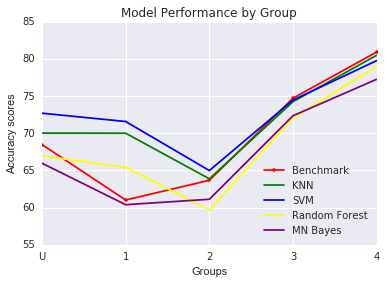

In [111]:

knn = [70.01,70,63.87,74.24,80.48]

svm = [72.69,71.57,64.98,74.46,79.76]

randomforest = [66.96,65.4,59.7,72.04,78.98]

MNbayes = [65.97,60.39,61.12,72.35,77.25]

benchmark = [68.47,61.02,63.67,74.71,80.91]


xaxis = [1,2,3,4,5]

plt.plot(xaxis, benchmark, marker='.', color='red', label='Benchmark')
plt.plot(xaxis, knn, color='green', label='KNN')
plt.plot(xaxis, svm, color='blue', label='SVM')
plt.plot(xaxis, randomforest, color='yellow', label='Random Forest')
plt.plot(xaxis, MNbayes, color='purple', label='MN Bayes')
plt.xticks([1, 2, 3, 4, 5], ['U', 1,2,3,4,5])
plt.legend(loc='lower right')
plt.xlabel('Groups')
plt.ylabel('Accuracy scores')
plt.title('Model Performance by Group')
plt.show()


